# Ridge Regression Code

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
from sklearn.utils import resample
from sklearn.model_selection import KFold
import seaborn as sns

In [5]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def design_matrix(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)		# Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

# Ridge Test over Polynomial Degree (No Resampling)





In [6]:
def Ridge_test_poly_degree(npoints, lower, upper, noise, sigma, nlambdas, scaling):

    np.random.seed(1)

    test_MSEs = []
    train_MSEs = []

    poly_order_range = range(lower, upper + 1)

    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)
    x_gr, y_gr = np.meshgrid(x,y)

    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(x)))

    for order in poly_order_range:
        X = design_matrix(x, y, order)

        X_train_origin, X_test_origin, z_train_origin, z_test_origin = train_test_split(X, z, test_size = 0.2, random_state = 1)

        X_train = X_train_origin - scaling *  np.mean(X_train_origin, axis=0)
        X_test = X_test_origin - scaling *  np.mean(X_train_origin, axis=0)
        z_train = z_train_origin - scaling *  np.mean(z_train_origin, axis=0)
        z_test = z_test_origin - scaling *  np.mean(z_train_origin, axis=0)
        
        # create identity matrix for beta calculation
        I = np.eye(X_train.shape[1],X_train.shape[1])

        test_MSEs_temp = np.zeros(nlambdas)
        train_MSEs_temp = np.zeros(nlambdas)
        
        # create nlambdas for the grid search in logarithmic base 10 space from -4 to 1
        lambdas = np.logspace(-4, 1, nlambdas)

        for i in range(nlambdas):
            lmb = lambdas[i]

            Ridgebeta = np.linalg.pinv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train

            ztildeRidge = X_train @ Ridgebeta
            zpredictRidge = X_test @ Ridgebeta

            test_MSEs_temp[i] = MSE(z_test,zpredictRidge)
            train_MSEs_temp[i] = MSE(z_train,ztildeRidge)
            
        train_MSEs.append(train_MSEs_temp)
        test_MSEs.append(test_MSEs_temp)        
    
    train_MSEs = np.array(train_MSEs)
    test_MSEs = np.array(test_MSEs)
    
    return test_MSEs, train_MSEs, lambdas

In [7]:
npoints = 100
lower = 1
upper = 5
nlambdas = 20
noise = 1
sigma = 0.1
scaling = 1
lambdas = np.logspace(-4, 1, nlambdas)
test_MSEs, train_MSEs, lambdas = Ridge_test_poly_degree(npoints, lower, upper, noise, sigma, nlambdas, scaling)

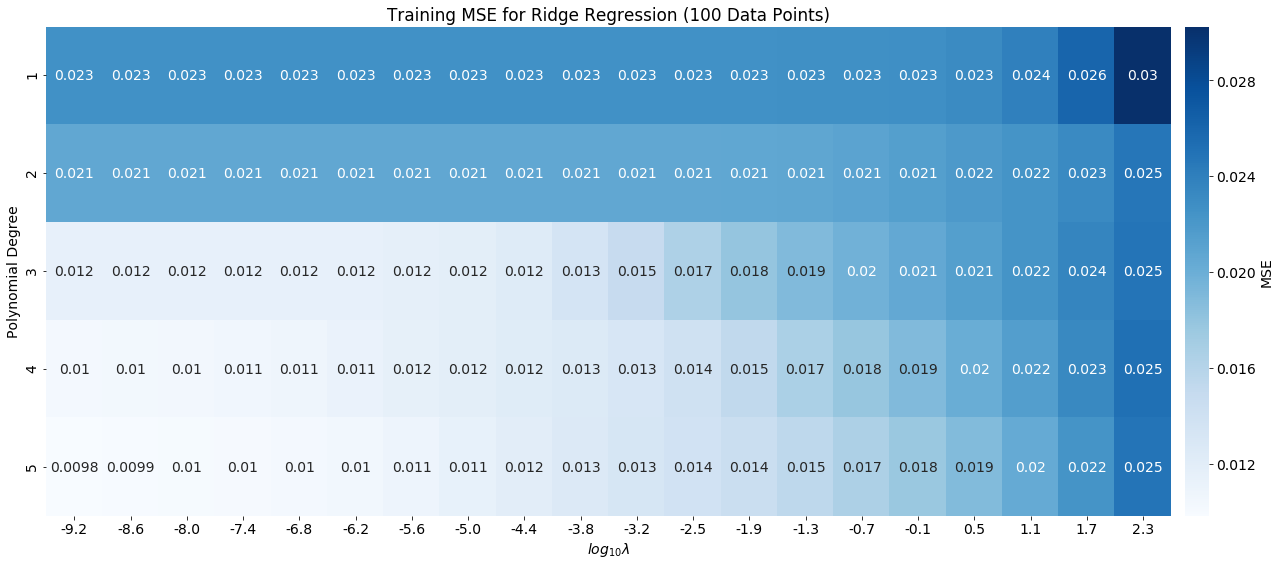

In [10]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(train_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE', 'pad': .01})
ax.set_title("Training MSE for Ridge Regression (100 Data Points)")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('ridge_poly_degree_training.jpg', dpi=1000, bbox_inches='tight')

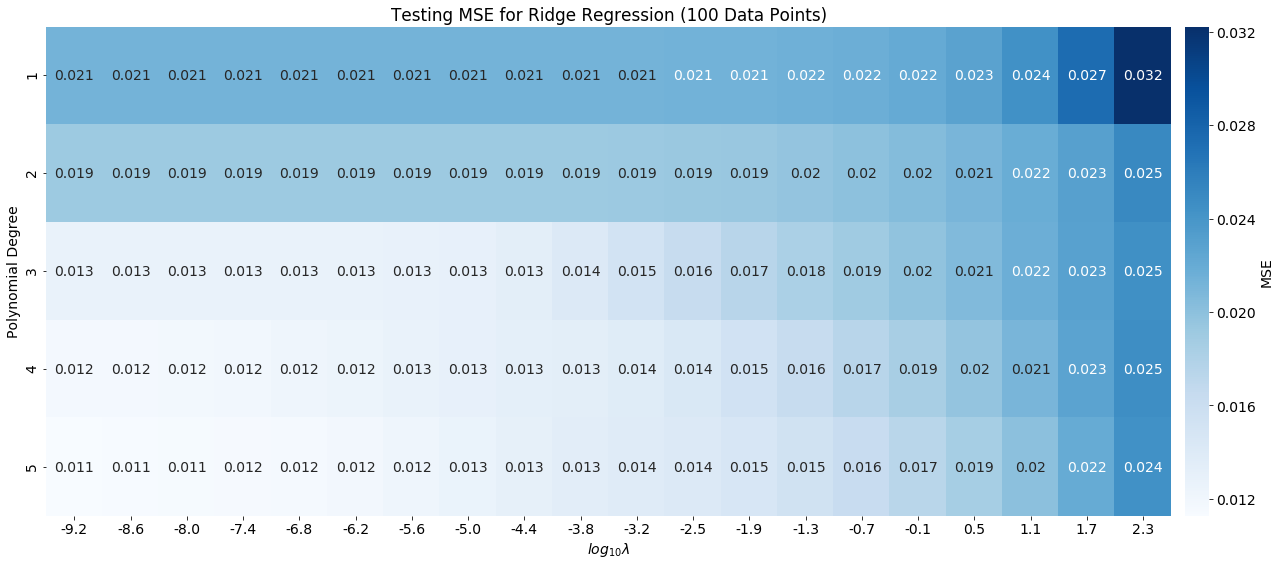

In [11]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(test_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE', 'pad': .01})
ax.set_title("Testing MSE for Ridge Regression (100 Data Points)")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('ridge_poly_degree_testing.jpg', dpi=1000, bbox_inches='tight')

# Bootstrap Resampling

In [12]:
def ridge_test_bootstrap(npoints, lower, upper, noise, sigma, nlambdas, nbootstraps, scaling):
    
    np.random.seed(4)
    errors = []
    train_errors = []
    biases = []
    variances = []
    poly_order_range = range(lower, upper+1)

    n_bootstraps = nbootstraps
    
    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)
    x_gr, y_gr = np.meshgrid(x,y)
    
    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(x)))
        
        
    for order in poly_order_range:

        X = design_matrix(x, y, order)

        X_train_origin, X_test_origin, z_train_origin, z_test_origin = train_test_split(X, z, test_size = 0.2, random_state = 1)

        X_train = X_train_origin - scaling *  np.mean(X_train_origin, axis=0)
        X_test = X_test_origin - scaling *  np.mean(X_train_origin, axis=0)
        z_train = z_train_origin - scaling *  np.mean(z_train_origin, axis=0)
        z_test = z_test_origin - scaling *  np.mean(z_train_origin, axis=0)

        z_test = np.expand_dims(z_test, 2)
        
        z_pred = np.empty((z_test.shape[0], npoints, n_bootstraps))

        I = np.eye(X_train.shape[1],X_train.shape[1])
        
        error_temp = np.zeros(nlambdas)
        train_error_temp = np.zeros(nlambdas)
        bias_temp = np.zeros(nlambdas)
        variance_temp = np.zeros(nlambdas)
     
        lambdas = np.logspace(-4, 1, nlambdas)
        
        for i in range(nlambdas):
            
            lmb = lambdas[i]
            for j in range(n_bootstraps):
                X_train_, z_train_ = resample(X_train, z_train)

                beta = np.linalg.pinv(X_train_.T @ X_train_+lmb*I) @ X_train_.T @ z_train_
                z_tilde = X_train_ @ beta

                z_pred[:, :, j] = X_test @ beta
                
            # calculate the average values for each lambda
            train_error_temp[i] = np.mean( np.mean((z_tilde - z_train_)**2, axis=1) )
            error_temp[i] = np.mean( np.mean((z_test - z_pred)**2, axis=2) )
            bias_temp[i] = np.mean( (z_test - np.mean(z_pred, axis=2, keepdims=True))**2 )
            variance_temp[i] = np.mean( np.var(z_pred, axis=2, keepdims=True) )

        train_errors.append(train_error_temp)
        errors.append(error_temp)
        biases.append(bias_temp)
        variances.append(variance_temp)

    train_errors = np.array(train_errors)    
    errors = np.array(errors)
    biases = np.array(biases)
    variances = np.array(variances)

    return errors, train_errors, biases, variances, lambdas

In [13]:
npoints = 100
lower = 1
upper = 5
nbootstraps = 100
noise = 1
sigma = 0.1
nlambdas = 20


bootstrap_test_MSEs, bootstrap_train_MSEs, biases, variances, lambdas = ridge_test_bootstrap(npoints, 
                                    lower, upper, noise, sigma, nlambdas, nbootstraps, scaling = 1)

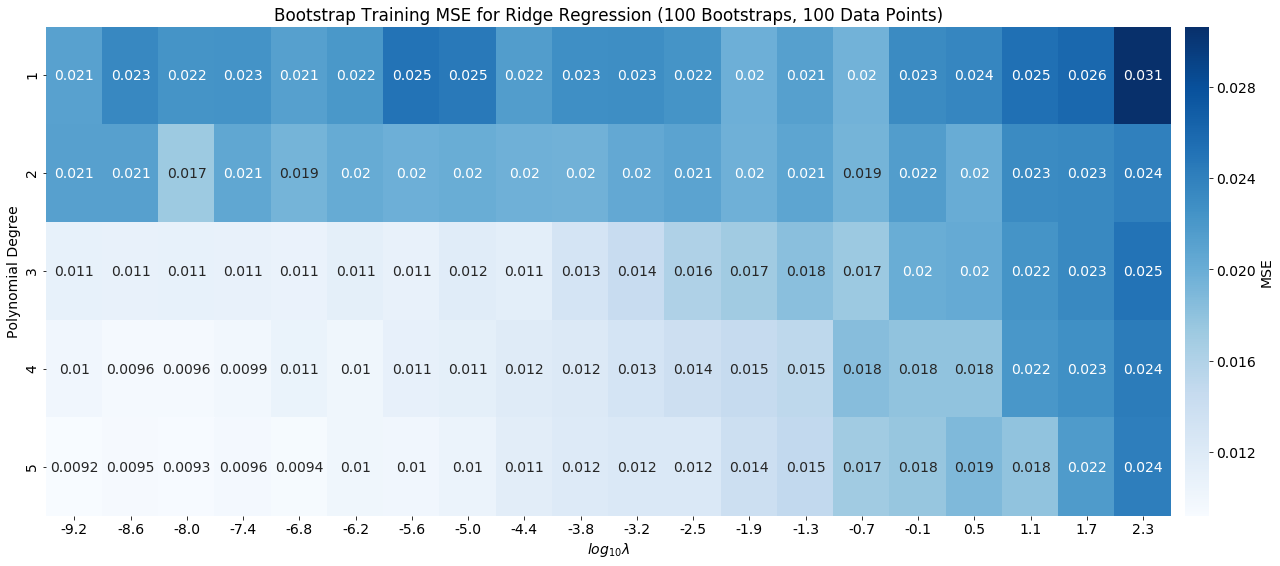

In [14]:
fig, ax = plt.subplots(figsize = (24,9))
sns.heatmap(bootstrap_train_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws = {'label': 'MSE', 'pad': .01})
ax.set_title("Bootstrap Training MSE for Ridge Regression (100 Bootstraps, 100 Data Points)")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('ridge_bootstrap_training.jpg', dpi=1000, bbox_inches='tight')

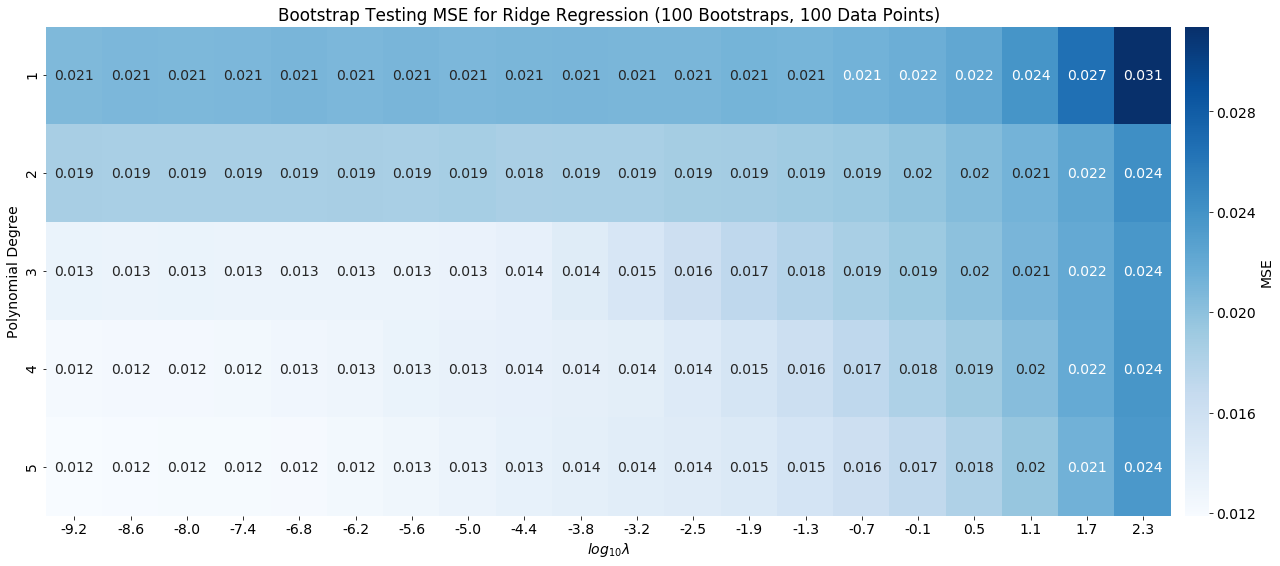

In [15]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(bootstrap_test_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE', 'pad': .01})
ax.set_title("Bootstrap Testing MSE for Ridge Regression (100 Bootstraps, 100 Data Points)")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('ridge_bootstrap_testing.jpg', dpi=1000, bbox_inches='tight')

# bias variance tradeoff plot using 20 data points, 100 bootstraps

In [16]:
npoints = 20
lower = 1
upper = 20
nbootstraps = 100
noise = 1
sigma = 0.1
nlambdas = 20


bootstrap_test_MSEs, bootstrap_train_MSEs, biases, variances, lambdas = ridge_test_bootstrap(npoints, 
                                    lower, upper, noise, sigma, nlambdas, nbootstraps, scaling = 1)

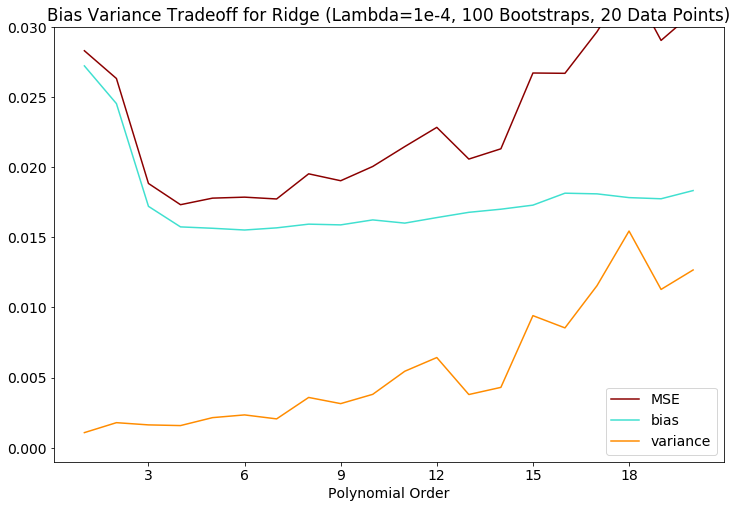

In [17]:
# lambda value to use (lowest 1e-4)
n = 0

poly_order_range = range(lower, upper+1)
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(poly_order_range, bootstrap_test_MSEs[:,n], color='darkred', label='MSE')
ax.plot(poly_order_range, biases[:,n], color='turquoise', label='bias')
ax.plot(poly_order_range, variances[:,n], color='darkorange', label='variance')
#ax.vlines(3, -1, 1, color='grey', linestyles='--')
ax.set_ylim(-0.001, 0.03)
ax.legend()
ax.set_xlabel('Polynomial Order')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Bias Variance Tradeoff for Ridge (Lambda=1e-4, 100 Bootstraps, 20 Data Points)')
fig.savefig('ridge_bias_variance.jpg', dpi=1000, bbox_inches='tight')

# Cross Validation

In [18]:
def ridge_CV(npoints, lower, upper, noise, sigma, nfolds, nlambdas, scaling):
    
    np.random.seed(7)
    
    poly_order_range = range(lower, upper+1)
    k = nfolds
    kfold = KFold(n_splits = k)
    scores_KFold_train = np.zeros((len(poly_order_range), nlambdas, k))
    scores_KFold_test = np.zeros((len(poly_order_range), nlambdas, k))

    x = np.linspace(0, 1, npoints)

    y = np.linspace(0, 1, npoints)

    x_gr, y_gr = np.meshgrid(x,y)
    
    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(x)))

    for order in poly_order_range:

        X = design_matrix(x, y, order)
    
        lambdas = np.logspace(-4, 1, nlambdas)
        
        for i in range(nlambdas):
            
            lmb = lambdas[i]
            j = 0
            for train_inds, test_inds in kfold.split(X):
                
                X_train_origin = X[train_inds]
                z_train_origin = z[train_inds]
                X_test_origin = X[test_inds]
                z_test_origin = z[test_inds]

                X_train = X_train_origin - scaling * np.mean(X_train_origin, axis=0)
                X_test = X_test_origin - scaling * np.mean(X_train_origin, axis=0)
                z_train = z_train_origin - scaling * np.mean(z_train_origin, axis=0)
                z_test = z_test_origin - scaling * np.mean(z_train_origin, axis=0)
                
                I = np.eye(X_train.shape[1],X_train.shape[1])

                beta = np.linalg.pinv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
                z_tilde = X_train @ beta
                z_pred = X_test @ beta

                scores_KFold_test[order-1, i, j] = MSE(z_pred, z_test)
                scores_KFold_train[order-1, i, j] = MSE(z_tilde, z_train)

                j += 1
            i += 1


    mse_KFold_test = np.mean(scores_KFold_test, axis = 2)
    mse_KFold_train = np.mean(scores_KFold_train, axis = 2)

    return mse_KFold_test, mse_KFold_train, lambdas


# CV grid search using 10 folds

In [19]:
npoints = 100
lower = 1
upper = 5
nfolds = 10
noise = 0
sigma = 0.1
nlambdas = 20
cv_test_MSEs, cv_train_MSEs, lambdas = ridge_CV(npoints, lower, upper, noise, sigma, nfolds, nlambdas, scaling=1)

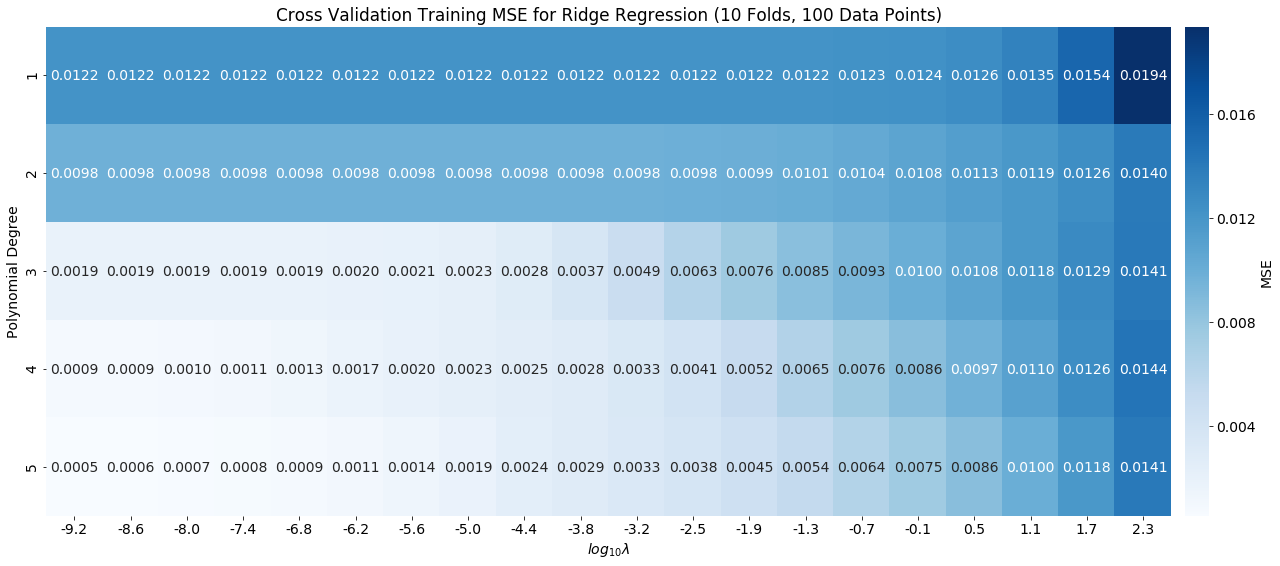

In [21]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(cv_train_MSEs, annot=True, fmt='.4f', ax=ax, cmap="Blues", cbar_kws={'label': 'MSE', 'pad': .01})
ax.set_title("Cross Validation Training MSE for Ridge Regression (10 Folds, 100 Data Points)")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('ridge_CV_training.jpg', dpi=1000, bbox_inches='tight')

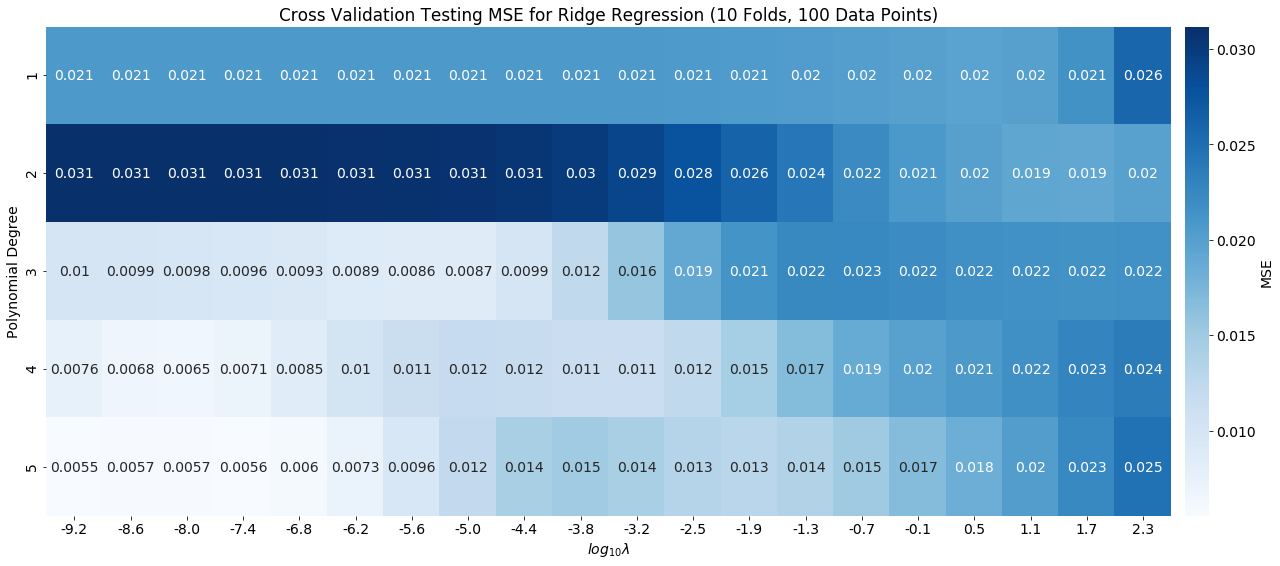

In [22]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(cv_test_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE', 'pad': .01})
ax.set_title("Cross Validation Testing MSE for Ridge Regression (10 Folds, 100 Data Points)")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('ridge_CV_testing.jpg', dpi=1000, bbox_inches='tight')